## Pyro code for examples in MBML book by John Winn
#### Based on version 0.7 of the early access version (www.mbmlbook.com)
Implementation and testing of ideas from the book

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import operator

import torch

import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist
from pyro import param
from pyro.poutine import trace
from pyro import condition
from pyro.optim import Adam, ClippedAdam
from pyro.infer import SVI, Trace_ELBO, HMC, MCMC, NUTS
from pyro.contrib.autoguide import AutoDiagonalNormal, AutoMultivariateNormal, AutoContinuous

from torch import tensor
from pprint import pprint


import pandas as pd
import matplotlib.pyplot as plt

from functools import reduce

from os.path import join, exists, basename


display('pyro version: {}'.format(pyro.__version__))

pyro.set_rng_seed(101)

/home/martin/mambaforge/envs/pyro/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'pyro version: 1.4.0'

# Chapter 2
## Assessing people's skils
#### Pages 47-68

<img src="images/skills.png" width="250"/>

**Problem statement:** 
The problem of assessing candidates for a job that requires certain skills is adressed. The idea is that candidates will take a multiple-choice test and we will use model-based machine learning to determine which skills each candidate has (and with what probability) given their answers in the test. We can then use this for tasks such as selecting a shortlist of candidates very likely to have a set of essential skills.

**Prior:** Several assumptions are used to construct the model.
1. Each candidate has either mastered each skill or not.
2. Before seeing any test results, it is equally likely that each candidate does or doesn't have any particular skill.
3. If a candidate has all of the skills neede for a question then they will get the question right, except one time in ten they will make a mistake.
4. If a candidate doesn't have all the skills needed for a question, they will pick an answer at random. Because this is a multiple-choice exam with five answers, there's one in five chance that they get the question right.
5. Whether the candidate gets a question right depends only on what skills that candidate has and not on anything else.

**Factor graph:** To capture these assumptions, for two skills and a single individual, a factor graph is constructed.
<img src="images/chapter_2.png" width="400"/>

**Implement the model**

In [2]:
def skill_model():
    '''
    A model representing the first three questions of the exam.
    '''
    csharp = pyro.sample('csharp', dist.Bernoulli(0.5))
    sql = pyro.sample('sql', dist.Bernoulli(0.5))
       
    hasskills = tensor(1.) if csharp and sql == tensor(1.) else tensor(0.)
        
    iscorrect1 = pyro.sample('iscorrect1', dist.Bernoulli(0.9 if csharp == tensor(1.) else 0.2))
    iscorrect2 = pyro.sample('iscorrect2', dist.Bernoulli(0.9 if sql == tensor(1.) else 0.2))
    iscorrect3 = pyro.sample('iscorrect3', dist.Bernoulli(0.9 if hasskills == tensor(1.) else 0.2))

**Let's take a look at the variables in the model**

CPU times: user 3.77 s, sys: 12.3 ms, total: 3.78 s
Wall time: 3.79 s


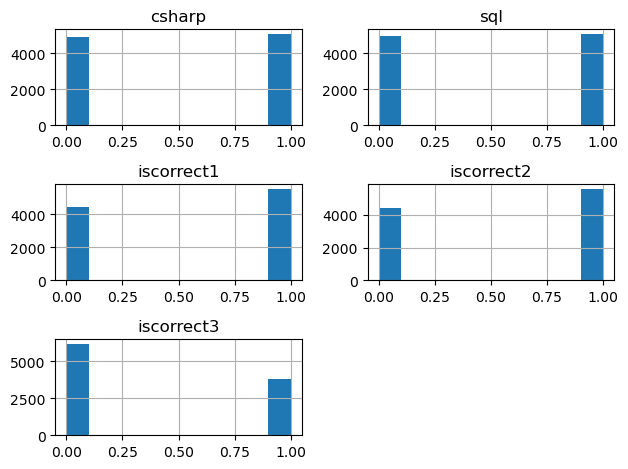

In [3]:
%%time 

traces = []
for _ in range(10000):
    tr = trace(skill_model).get_trace()
    values = {
        name: props['value'].item()
        for (name, props) in tr.nodes.items()
        if props['type'] == 'sample'
    }
    traces.append(values)

_ = pd.DataFrame(traces).hist()
plt.tight_layout()

## Variational inference

**Define a guide function to help me solve conditioned models**

In [4]:
def skill_guide():
    '''
    Guide function used to find optimal values of latent variables.
    '''
    valid_prob = dist.constraints.interval(0., 1.)
    cs_p = param('cs_p', tensor(0.5), constraint=valid_prob)
    sq_p = param('sq_p', tensor(0.5), constraint=valid_prob)
    
    csharp = pyro.sample('csharp', dist.Bernoulli(cs_p))
    sql = pyro.sample('sql', dist.Bernoulli(sq_p))
        
    hasskills = tensor(1.) if csharp and sql == tensor(1.) else tensor(0.)
        
    iscorrect1 = pyro.sample('iscorrect1', dist.Bernoulli(0.9 if csharp == tensor(1.) else 0.2))
    iscorrect2 = pyro.sample('iscorrect2', dist.Bernoulli(0.9 if sql == tensor(1.) else 0.2))
    iscorrect3 = pyro.sample('iscorrect3', dist.Bernoulli(0.9 if hasskills == tensor(1.) else 0.2))

**Now get the latent variable probabilities for all outcomes**

tensor(0.) tensor(0.) tensor(0.)


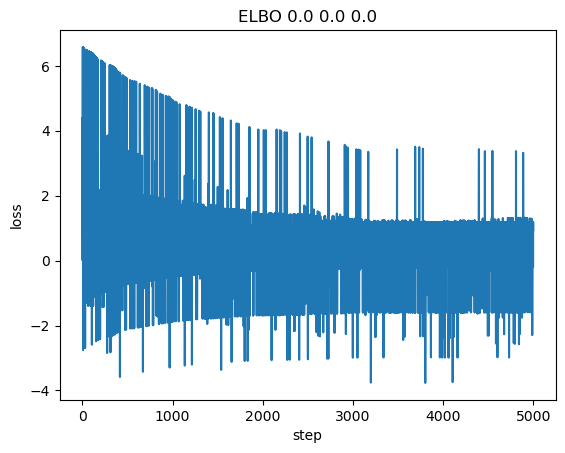

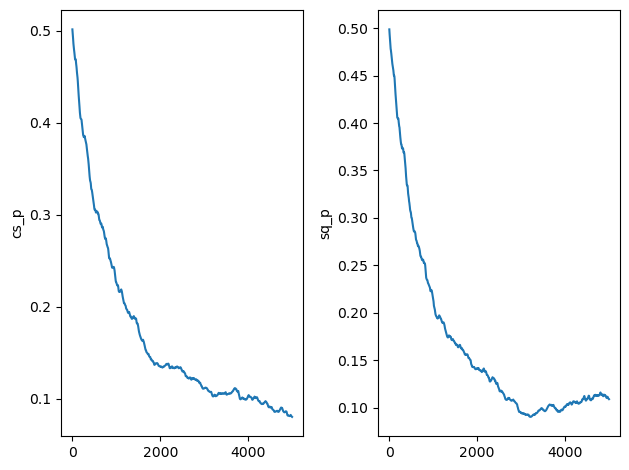

tensor(1.) tensor(0.) tensor(0.)


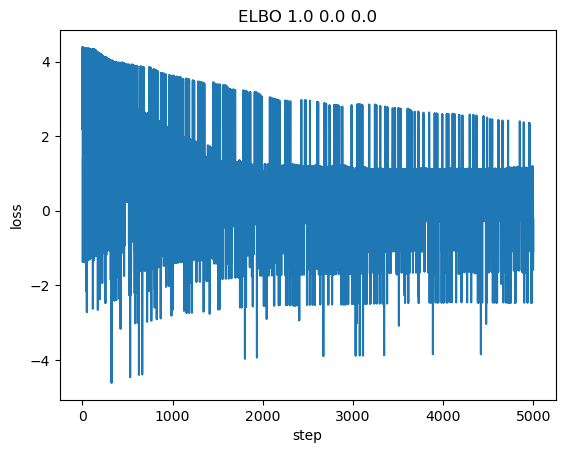

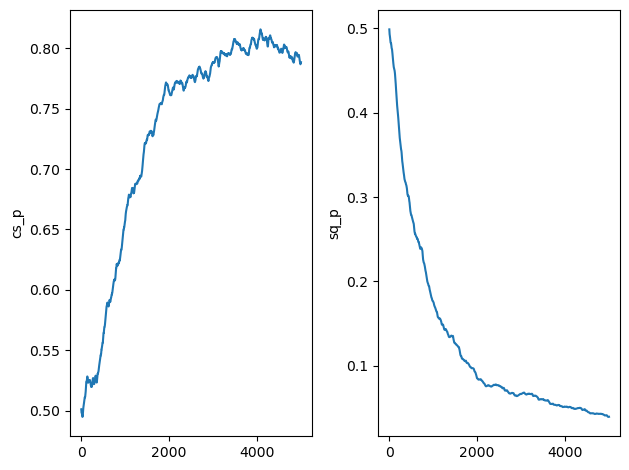

tensor(0.) tensor(1.) tensor(0.)


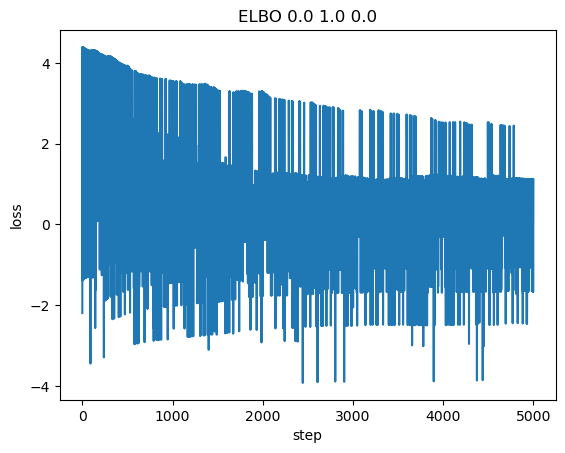

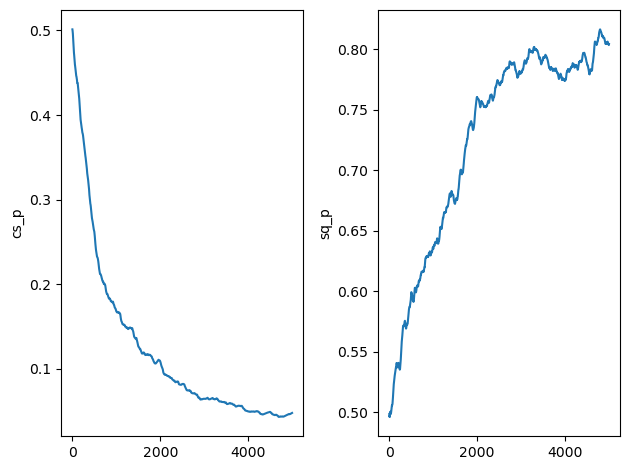

tensor(1.) tensor(1.) tensor(0.)


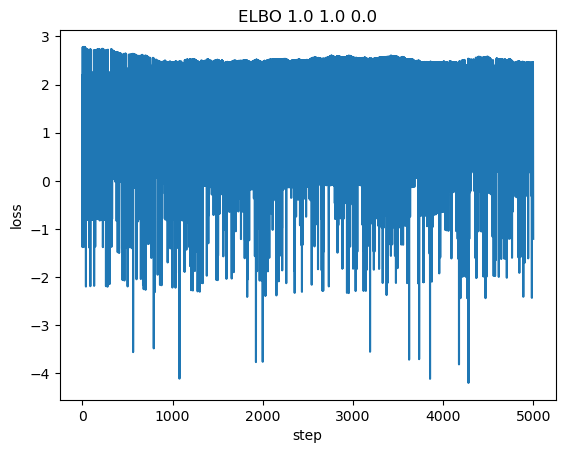

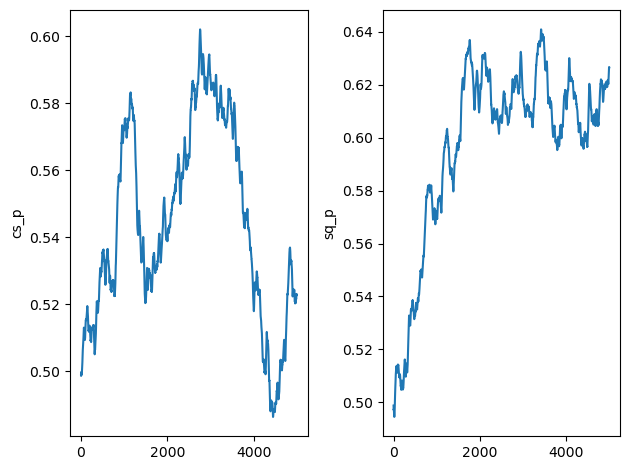

tensor(0.) tensor(0.) tensor(1.)


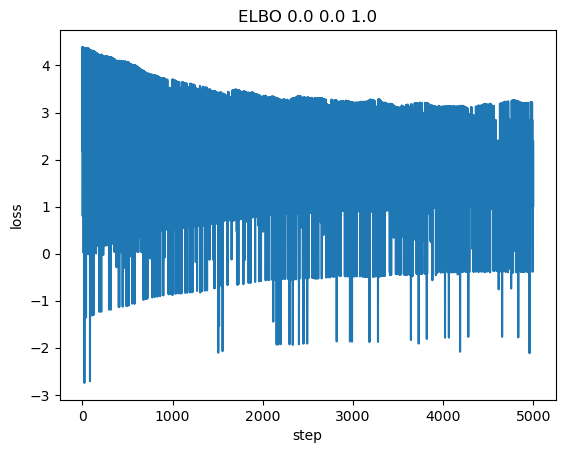

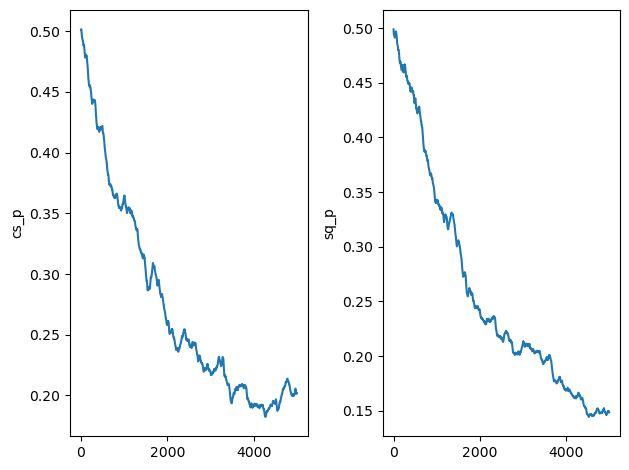

tensor(1.) tensor(0.) tensor(1.)


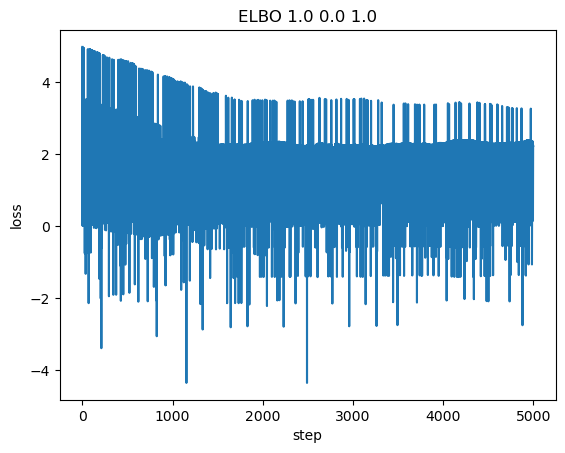

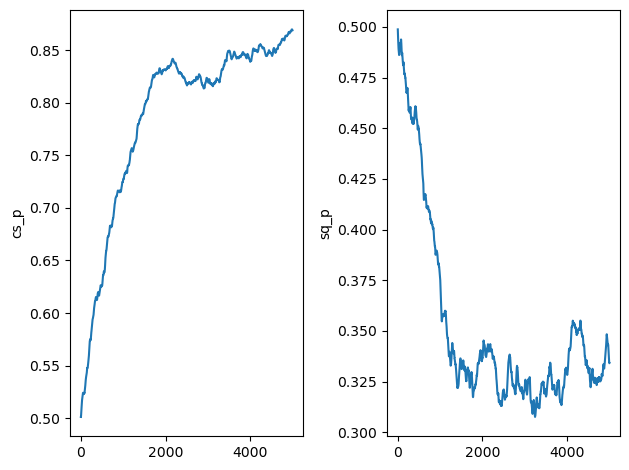

tensor(0.) tensor(1.) tensor(1.)


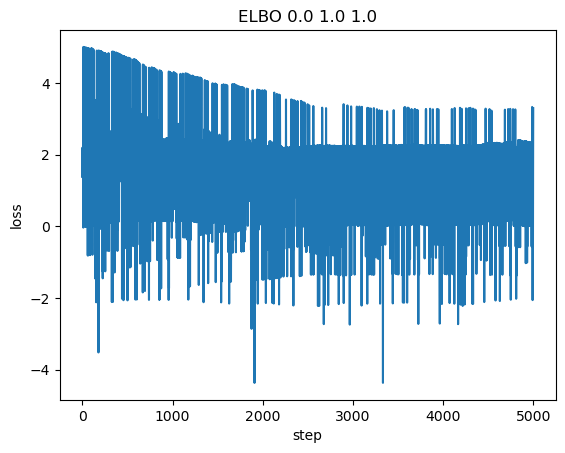

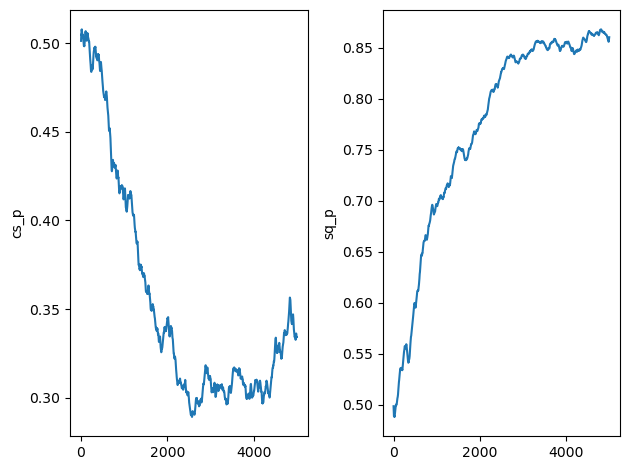

tensor(1.) tensor(1.) tensor(1.)


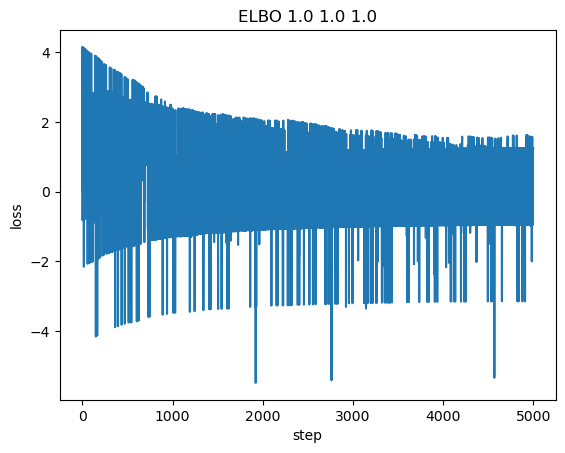

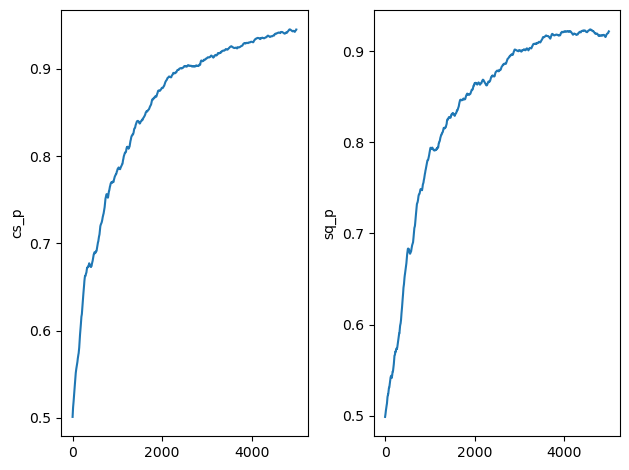

CPU times: user 1min 25s, sys: 304 ms, total: 1min 25s
Wall time: 1min 28s


In [5]:
%%time

data = {'iscorrect1':[], 'iscorrect2':[], 'iscorrect3':[], 'csharp':[], 'sql':[]}

for k in (tensor(0.), tensor(1.)):
    for j in (tensor(0.), tensor(1.)):
        for i in (tensor(0.), tensor(1.)):
            print(i,j,k)
            
            # remove previous
            pyro.clear_param_store()

            # Condition the model
            cond_model = condition(skill_model, {
                "iscorrect1": i,
                "iscorrect2": j,
                "iscorrect3": k
            })


#             cond_test_guide = condition(test_guide, {
#                 "iscorrect1": i,
#                 "iscorrect2": j,
#                 "iscorrect3": k
#             })

            adam = Adam({"lr": 0.005, "betas": (0.90, 0.999)})
            svi = SVI(model=cond_model, 
                      guide=skill_guide, 
                      optim=adam, 
                      loss=Trace_ELBO())

            param_vals = []
            losses = []
            cs = []
            sq = []
            for _ in range(10000):
                losses.append(svi.step())
                cs.append(pyro.param("cs_p").item())
                sq.append(pyro.param("sq_p").item())
                #param_vals.append({p: param(p).item() for p in ["cs_p", "sq_p"]})

            
            # plot the parameter value
            #pd.DataFrame(param_vals).plot(subplots=True)
            
            # plot losses
            plt.plot(losses)
            plt.title("ELBO {} {} {}".format(i, j, k))
            plt.xlabel("step")
            plt.ylabel("loss")
            plt.show()
            
            
            plt.subplot(1,2,1)
            plt.plot(cs)
            plt.ylabel('cs_p')

            plt.subplot(1,2,2)
            plt.plot(sq)
            plt.ylabel('sq_p')
            plt.tight_layout()
            plt.show()
            
            # what is the probabilities now?
            tr = trace(skill_guide).get_trace()
            
            data['iscorrect1'].append(True if i == tensor(1.) else False)
            data['iscorrect2'].append(True if j == tensor(1.) else False)
            data['iscorrect3'].append(True if k == tensor(1.) else False)
            data['csharp'].append(tr.nodes['cs_p']['value'].item())
            data['sql'].append(tr.nodes['sq_p']['value'].item())


df = pd.DataFrame(data)


In [6]:
display(df)

,iscorrect1,iscorrect2,iscorrect3,csharp,sql
0,False,False,False,0.080304,0.108914
1,True,False,False,0.788405,0.039507
2,False,True,False,0.047746,0.804132
3,True,True,False,0.522853,0.626583
4,False,False,True,0.201857,0.148499
5,True,False,True,0.868813,0.334157
6,False,True,True,0.334208,0.860080
7,True,True,True,0.944975,0.921786


Looking at the optimization traces there is room for improvement. The values for some of the latent variables do not stabilize before the process is over. Even so, the results nicely agree with the ones in Table 2.4 on page 67 of the book.

## Moving to real data
#### Pages 78 to y

**Generalizing the model:** The dataset available for this problem comprises 48 questions answered by 22 individuals. In order to analyze this data we need to generalize the model, as the current one only works for one person and three questions. We do this using plates.

**Factor graph:** We use one plate across the skills and another across questions. This makes the model generalizable to any number of skills and questions. In addition we need a subarray factor that connects **skillsNeeded** with **relevantSkills**. This array tells which skills are needed for which questions. The **skillsNeeded** array has to be provided and each element in this contains a separate array of integers specifying the skills needed for that question.

<img src="images/chapter_2_plate.png" width="400"/>



**First load the data**

In [7]:
# A mask indicating which skills are needed for which questions
skills = pd.read_csv(join('data', 'ch2', 'SkillsQuestionsMask.csv'), sep=',', header=None)
skills = skills

display(skills.head())
display(skills.shape)


# For each of the individuals data which indicates whether they answered correct or not
questions = pd.read_csv(join('data', 'ch2', 'IsCorrect.csv'), sep=',', header=None).to_numpy().astype(float)

display(questions)
display(questions.shape)

,0,1,2,3,4,5,6
0,True,False,False,False,False,False,False
1,True,False,False,False,False,False,False
2,True,False,False,False,False,False,True
3,True,False,False,False,False,False,True
4,True,False,False,False,False,False,False


(48, 7)

array([[1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.],
       [1., 1., 0., ..., 1., 1., 0.],
       ...,
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 0., 0., ..., 1., 1., 1.],
       [1., 1., 1., ..., 1., 1., 1.]])

(48, 22)

#### Make the plot from Figure 2.14
Light yellow indicates True and black is False. In the first figure this indicates whether a skill is needed for the question. In the second plot it indicates whether peoples responses were correct or not.

(48, 7)

(48, 22)

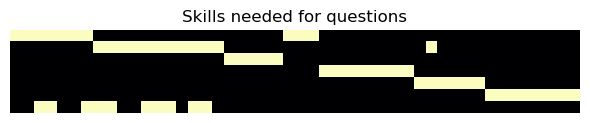

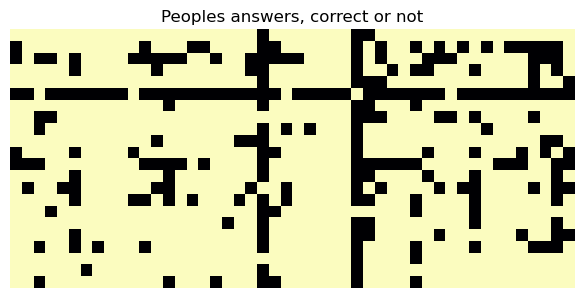

In [8]:
# Skills needed for questions
fig, ax2 = plt.subplots(figsize=(6, 20))
img = ax2.imshow(skills.transpose(),
                 interpolation='nearest',
                 cmap = 'magma',
                vmin=0,
                vmax=1) 
plt.axis('off')
plt.title("Skills needed for questions")
fig.tight_layout()


# Peoples answers, correct or not
fig, ax1 = plt.subplots(figsize=(6, 3))
img = ax1.imshow(questions.transpose(),
                 interpolation='nearest',
                 cmap = 'magma',
                vmin=0,
                vmax=1) 
plt.axis('off')
plt.title('Peoples answers, correct or not')
fig.tight_layout()


display(skills.shape)
display(questions.shape)

The **skillsNeeded** needs to be an array of indexes.

In [9]:
# convert skills needed to a list of indexes
skills_needed_list = [skills.index[skills[s] == True].tolist() for s in skills.columns]
skills_needed_list

[[0, 1, 2, 3, 4, 5, 6, 23, 24, 25],
 [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 35],
 [18, 19, 20, 21, 22],
 [26, 27, 28, 29, 30, 31, 32, 33],
 [34, 35, 36, 37, 38, 39],
 [40, 41, 42, 43, 44, 45, 46, 47],
 [2, 3, 6, 7, 8, 11, 12, 13, 15, 16]]

In [10]:

skills_key = pd.read_csv('http://www.mbmlbook.com/Downloads/LearningSkills_Real_Data_Experiments-Original-Inputs-Quiz-SkillsQuestionsMask.csv', header=None)
skills_needed = []
for index, row in skills_key.iterrows():
    skills_needed.append([i for i,x in enumerate(row) if x])
skills_needed

[[0],
 [0],
 [0, 6],
 [0, 6],
 [0],
 [0],
 [0, 6],
 [1, 6],
 [1, 6],
 [1],
 [1],
 [1, 6],
 [1, 6],
 [1, 6],
 [1],
 [1, 6],
 [1, 6],
 [1],
 [2],
 [2],
 [2],
 [2],
 [2],
 [0],
 [0],
 [0],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [3],
 [4],
 [1, 4],
 [4],
 [4],
 [4],
 [4],
 [5],
 [5],
 [5],
 [5],
 [5],
 [5],
 [5],
 [5]]

In [11]:
def skill_model_plate(data):
    num_questions = 48 #data.shape[1]
    num_people = 22 #data.shape[0]
    num_skills = 7

    with pyro.plate("participants", num_people) as p:
        
        # do the people have the 7 skills?
        skills = []
        for i in pyro.plate("skills", num_skills):

            true_skills = pyro.sample('true_skills_{}'.format(i),
                                      dist.Beta(0.1, 0.1))
            
            skills.append(pyro.sample("skill_{}".format(i),
                                     dist.Bernoulli(true_skills),
                                     infer={"enumerate": "parallel"}))

        for q in pyro.plate("questions", num_questions):
            
            # generate True/False list indicating, for each question, 
            # whether a person has the skills needed  
            has_skills = reduce(operator.mul,
                    [skills[i] for i in skills_needed[q]]).float()
            
            prob_correct = has_skills * 0.9 + (1 - has_skills) * 0.2

            pyro.sample("isCorrect_p{}_q{}".format(p, q),
                        dist.Bernoulli(prob_correct), obs=data[q])


# Clear named parameters so that runs don't interfere
pyro.clear_param_store()


my_kernel = NUTS(skill_model_plate)


my_mcmc = MCMC(my_kernel,
               num_samples=100,
               warmup_steps=100)

my_mcmc.run(tensor(questions))

# store results for later plotting
results = my_mcmc.get_samples()

Sample: 100%|██████████| 110/110 [02:52,  1.57s/it, step size=8.25e-01, acc. prob=0.748]


In [12]:
results

{'true_skills_0': tensor([[4.7014e-01, 8.9847e-01, 8.4002e-01,  ..., 1.0000e+00, 8.1392e-01,
          9.9221e-01],
         [9.9999e-01, 9.9995e-01, 6.8646e-06,  ..., 1.0000e+00, 9.9089e-01,
          7.5984e-01],
         [8.3239e-01, 1.0000e+00, 1.1279e-01,  ..., 1.0000e+00, 9.9887e-01,
          9.7839e-01],
         ...,
         [9.9994e-01, 9.9390e-01, 5.9598e-01,  ..., 1.0000e+00, 1.0000e+00,
          9.9997e-01],
         [1.0000e+00, 7.8205e-01, 3.9640e-03,  ..., 1.0000e+00, 9.9999e-01,
          9.9978e-01],
         [1.0000e+00, 9.7883e-01, 5.9383e-02,  ..., 1.0000e+00, 9.9999e-01,
          9.9998e-01]], dtype=torch.float64),
 'true_skills_1': tensor([[9.9861e-01, 7.5621e-02, 2.2164e-03,  ..., 1.0000e+00, 9.9685e-01,
          9.9993e-01],
         [1.0000e+00, 1.0000e+00, 5.6684e-08,  ..., 9.9982e-01, 9.7160e-01,
          1.0000e+00],
         [9.9994e-01, 9.5623e-01, 4.4868e-09,  ..., 4.9834e-01, 9.9995e-01,
          9.9999e-01],
         ...,
         [9.9992e-01, 9.

### Plot the results

/home/martin/mambaforge/envs/pyro/lib/python3.7/site-packages/ipykernel_launcher.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


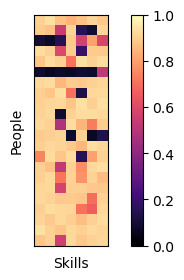

In [13]:
res_mean = []
for i in range(0, 7):
    res_mean.append(results['true_skills_{}'.format(i)].numpy().mean(axis=0))
    
res_mean = np.array(res_mean)  
    
fig, ax1 = plt.subplots(figsize=(6, 3))
img = ax1.imshow(res_mean.transpose(),
                 interpolation='nearest',
                 cmap = 'magma',
                vmin=0,
                vmax=1)

plt.xlabel('Skills')
plt.ylabel('People')

plt.xticks([])
plt.yticks([])

fig.colorbar(img)

fig.show()


# Work in progress !!!

## 2.6 Learning the guess probabilities

**Build the model using plates**
Was very tricky to make things work with the subarray. Got guidance from https://forum.pyro.ai/t/model-based-machine-learning-book-chapter-2-skills-example-in-pyro-tensor-dimension-issue/464/3.

In [14]:
def guess_prob_model(data):
    num_questions = 48 #data.shape[1]
    num_people = 22 #data.shape[0]
    
    prob_mistake = 0.1
    prob_guess = 0.2
    
    alpha0 = torch.ones(48) * 2.5
    beta0 = torch.ones(48) * 7.5

    guess_probs = pyro.sample('guess_prob',
                              dist.Beta(alpha0, beta0).independent(1))

    with pyro.plate("participants", num_people) as p:

        # do the people have the 7 skills?
        skills = []
        for i in pyro.plate("skills", 7):
            skills.append(pyro.sample("skill_{}".format(i),
                                     dist.Bernoulli(0.5),
                                     infer={"enumerate": "parallel"}))

            
        for q in pyro.plate("questions", num_questions):
            has_skills = reduce(operator.mul,
                                [skills[i] for i in skills_needed[q]]).float()
            
            prob_correct = has_skills * (1 - prob_mistake) + (1 - has_skills) * guess_probs[q]

            pyro.sample("isCorrect{}".format(q),
                        dist.Bernoulli(prob_correct), obs=data[q])


# Clear named parameters so that runs don't interfere
pyro.clear_param_store()


my_kernel = NUTS(guess_prob_model)


my_mcmc = MCMC(my_kernel,
               num_samples=100,
               warmup_steps=10)

my_mcmc.run(tensor(questions))

# store results for later plotting
results = my_mcmc.get_samples()

Sample: 100%|██████████| 110/110 [01:01,  1.79it/s, step size=2.25e-01, acc. prob=0.920]


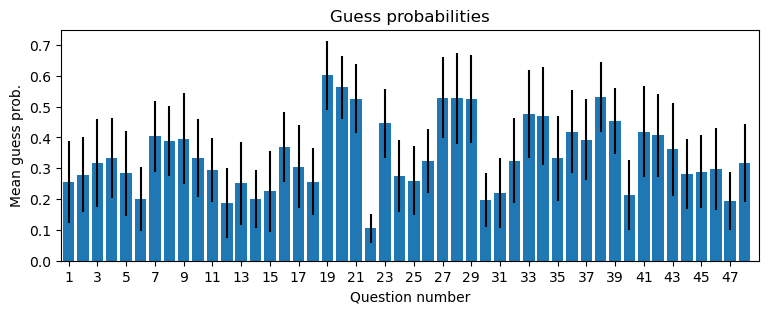

In [15]:
plt.figure(figsize=(9,3))
plt.bar(x=list(range(1, results['guess_prob'].shape[1]+1)), 
        height=results['guess_prob'].mean(axis=0),
        yerr=results['guess_prob'].std(axis=0))
plt.xlabel('Question number')
plt.ylabel('Mean guess prob.')
plt.xlim([0.5, results['guess_prob'].shape[1]+1])
plt.xticks(np.arange(1, results['guess_prob'].shape[1]+1, step=2))
plt.title('Guess probabilities')
plt.show()

**Load data containing each persons self-assessment of their skills as well as the answer they give for each question**

In [16]:
# load data
table26 = pd.read_csv(join('data', 'ch2', 'RawResponsesAsDictionary.csv'), sep=',', index_col=0)

# drop the first row, which contains the correct answers for each question
table26 = table26.drop('ANS')

display(table26.head())
display(table26.tail())

,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,Q3,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
#,,,,,,,,,,,,,,,,,,,,,
P1,True,True,True,True,False,True,True,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P2,True,True,True,True,False,False,True,1,4,3,...,5,1,1,4,3,3,4,4,3,1
P3,False,False,False,True,False,True,False,3,4,5,...,2,1,5,4,2,5,5,3,3,1
P4,True,True,False,True,False,False,False,2,4,3,...,2,5,5,4,2,5,4,2,3,1
P5,True,True,False,False,False,False,True,2,4,3,...,2,1,5,4,2,5,5,2,2,5


,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,Q3,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
#,,,,,,,,,,,,,,,,,,,,,
P18,True,True,False,False,False,False,True,2,4,3,...,2,1,5,4,2,2,2,2,3,5
P19,True,True,False,False,True,False,True,2,4,5,...,2,5,5,4,2,5,4,1,5,1
P20,True,True,True,True,False,True,True,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P21,True,True,False,True,True,True,True,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P22,True,True,True,True,False,True,False,2,4,4,...,2,1,5,4,2,5,2,2,2,1


# Data extraction
I want do extrtact the data from `objml` format into tab-separated files.

In [19]:
import xml.etree.ElementTree as ET
tree = ET.parse('./data/ch2/InputData.objml')
root = tree.getroot()


for child in root:
    print(child.tag)
    
# get a list of the skills
print('\n<getting list of skills>')
print(root[0].tag)
print(root[0][0].tag)
questions = []
for child in root[0][0]:
    #print(child.text)
    questions.append(child.text)
print(questions)
    
    
# get which skills are needed for each question
print('\n<getting skills for questions>')
print(root[0].tag)
print(root[0][1].tag)
skillsforq = []
for child in root[0][1]:
    temp = []
    for grandchild in child:
        #print(grandchild.text)
        temp.append(int(grandchild.text))
    skillsforq.append(temp)
print(skillsforq)


# get raw responses
print('\n<getting raw responses>')
print(root[1].tag)
raw = []
for child in root[1]:
    temp = []
    for grandchild in child:
        #print(grandchild.text)
        temp.append(int(grandchild.text))
    raw.append(temp)
print(raw)


# get whether response is correct or not
print('\n<getting response correctness>')
print(root[2].tag)
iscorrect = []
for child in root[2]:
    temp = []
    for grandchild in child:
        #print(grandchild.text)
        temp.append(True if grandchild.text == 'True' else False)
    iscorrect.append(temp)
print(iscorrect)


# get correct answers for the questions
print('\n<getting correct answers>')
print(root[3].tag)
correct = []
for child in root[3]:
    correct.append(int(child.text))
print(correct)


# get which skills participants state they have
print('\n<getting stated skills>')
print(root[4].tag)
haveskill = []
for child in root[4]:
    temp = []
    for grandchild in child:
        temp.append(True if grandchild.text == 'True' else False)
    haveskill.append(temp)
print(haveskill)


### Start putting the stuff together ###

# add in a row of NaN to stated skills (since the first row aren't participant answers)
haveskill.insert(0, ['NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN'])
print(haveskill)

# add in the correct answers in front of the given answers
raw.insert(0, correct)
print(raw)

Quiz
RawResponses
IsCorrect
CorrectAnswers
StatedSkills

<getting list of skills>
Quiz
SkillNames
['1: Core programming skills (i.e. storage, data types, decision structures, error handling, algorithms)', '2: Object Oriented Programming (i.e. classes, inheritance, polymorphism, encapsulation)', '3: Application Life Cycle Management', '4: Web Applications (development, hosting, services)', '5: Microsoft Windows desktop applications', '6: Databases & SQL', '7: C#']

<getting skills for questions>
Quiz
SkillsForQuestion
[[0], [0], [0, 6], [0, 6], [0], [0], [0, 6], [1, 6], [1, 6], [1], [1], [1, 6], [1, 6], [1, 6], [1], [1, 6], [1, 6], [1], [2], [2], [2], [2], [2], [0], [0], [0], [3], [3], [3], [3], [3], [3], [3], [3], [4], [1, 4], [4], [4], [4], [4], [5], [5], [5], [5], [5], [5], [5], [5]]

<getting raw responses>
RawResponses
[[2, 4, 3, 3, 4, 3, 4, 5, 1, 5, 1, 1, 1, 4, 3, 1, 2, 3, 2, 3, 4, 5, 2, 2, 2, 4, 2, 3, 3, 2, 1, 4, 4, 5, 3, 4, 2, 1, 2, 1, 5, 4, 2, 5, 2, 2, 2, 1], [1, 4, 3, 3, 4, 1,

#### Make dataframe from this data (same as table 2.6)

In [20]:
rownames = ['ANS'] + ['P{}'.format(s) for s in range(1, 23)]
colnames = ['S{}'.format(s) for s in range(1, 8)] + ['Q{}'.format(s) for s in range(1, len(raw[0])+1)]

answers_df = pd.DataFrame(raw)
answers_df.index = rownames
answers_df.columns = colnames[7:]

skills_df = pd.DataFrame(haveskill)
skills_df.index = rownames
skills_df.columns = colnames[:7]

table26 = skills_df.join(answers_df)

table26.to_csv('./data/ch2/table26.tsv', sep='\t', index=True)

display(table26)

,S1,S2,S3,S4,S5,S6,S7,Q1,Q2,Q3,...,Q39,Q40,Q41,Q42,Q43,Q44,Q45,Q46,Q47,Q48
ANS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P1,True,True,True,True,False,True,True,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P2,True,True,True,True,False,False,True,1,4,3,...,5,1,1,4,3,3,4,4,3,1
P3,False,False,False,True,False,True,False,3,4,5,...,2,1,5,4,2,5,5,3,3,1
P4,True,True,False,True,False,False,False,2,4,3,...,2,5,5,4,2,5,4,2,3,1
P5,True,True,False,False,False,False,True,2,4,3,...,2,1,5,4,2,5,5,2,2,5
P6,False,False,False,False,False,False,False,1,3,3,...,4,4,4,2,4,3,1,5,1,3
P7,True,True,False,False,False,False,False,2,4,3,...,2,1,5,4,2,5,2,2,2,1
P8,True,True,False,False,False,False,True,2,4,5,...,2,5,5,4,2,5,4,2,2,1
P9,True,True,False,False,True,True,True,2,4,1,...,2,1,2,4,2,5,2,2,2,1
